# SARIMAX

In [1]:
from statsmodels.tsa.stattools import adfuller
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
%load_ext autoreload
%autoreload 2

## Data exploration

In [3]:
from electricity_price_predictor.data_2 import get_price, get_shifted_price

In [4]:
df= get_shifted_price()
df.head()

,price
time,
2015-01-01 00:00:00,25.02
2015-01-01 01:00:00,18.29
2015-01-01 02:00:00,16.04
2015-01-01 03:00:00,14.60
2015-01-01 04:00:00,14.95


In [5]:
df_daily_mean = df.resample('D').mean()

In [6]:
df_daily_mean.head()

,price
time,
2015-01-01,16.310417
2015-01-02,4.970417
2015-01-03,15.291667
2015-01-04,21.064167
2015-01-05,37.997500


<AxesSubplot:xlabel='time'>

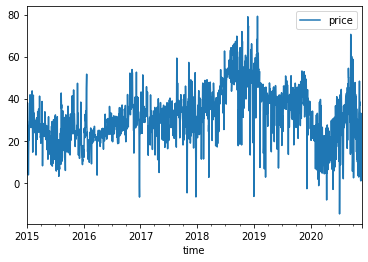

In [7]:
df_daily_mean.plot()

### Decomposition

- components:
 - Trend
 - Seaonal
 - cyclical 

- choose:
 - additive or multiplicative decomposition?   plot the residuls of both models and decide  

- statsmodel.tsa [Deterministic Processes](https://www.statsmodels.org/stable/tsa.html#)      

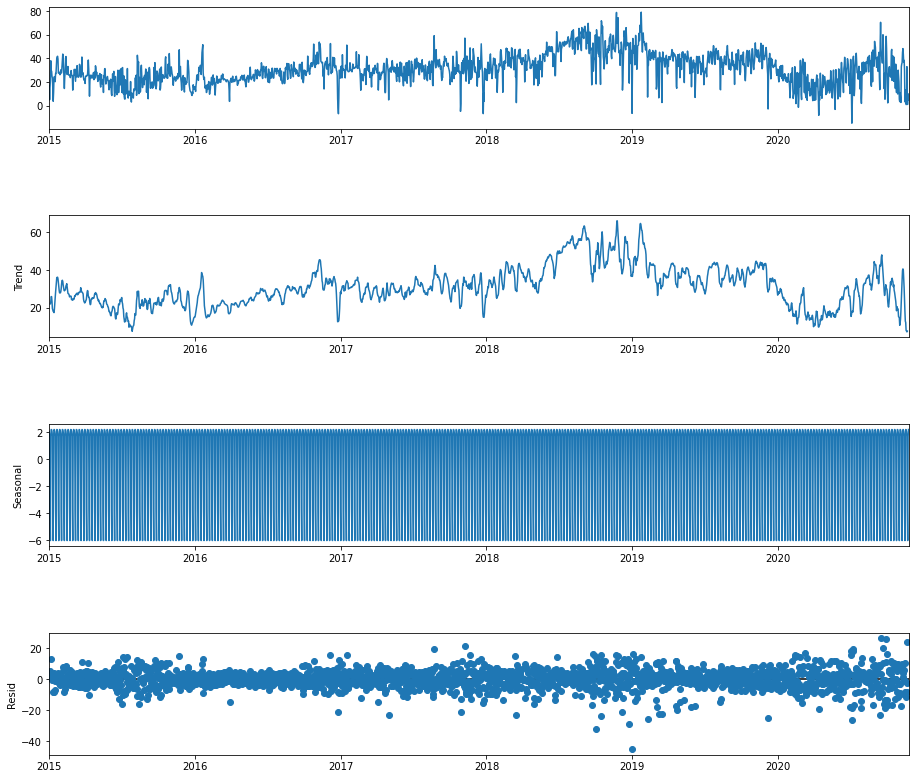

In [20]:
# Decomposition of df_daily_mean for 5 years
result_add = seasonal_decompose(df_daily_mean, model='additive')
fig = result_add.plot()
fig.set_size_inches(14, 12);

In [21]:
# checkout whether the residuals stationarity
print('additive resid: ', adfuller(result_add.resid.dropna())[1])

additive resid:  2.5850129570992833e-30


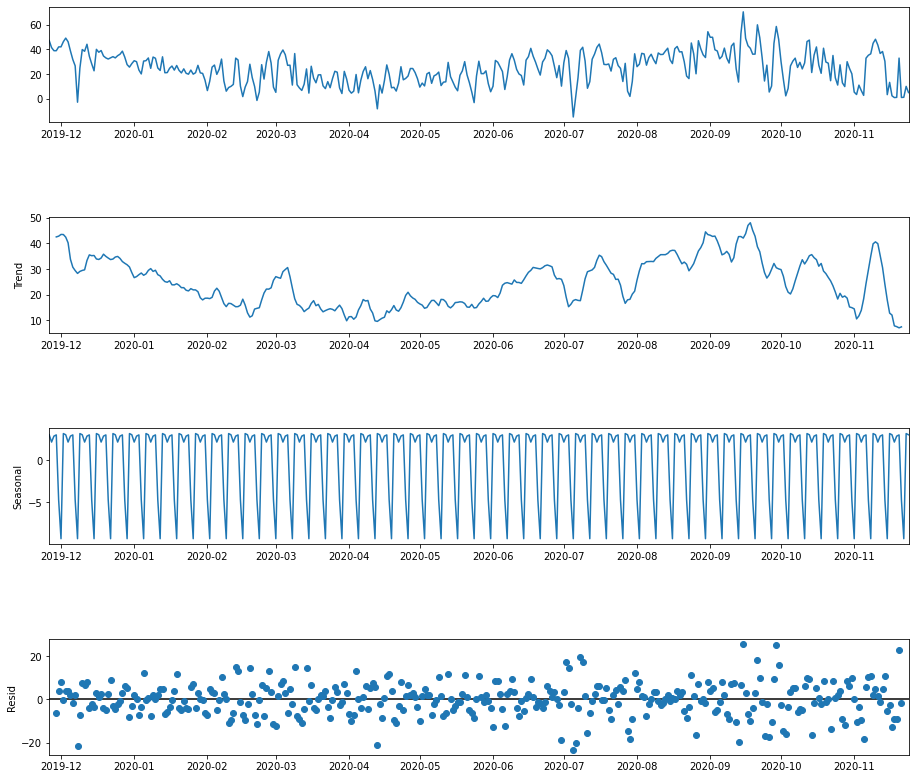

In [9]:
# Decomposition of df_daily_mean for year 2019-2020 
result_add = seasonal_decompose(df_daily_mean[-365:], model='additive')
fig = result_add.plot()
fig.set_size_inches(14, 12);

In [10]:
# Decomposition of hourly df for year 2019-2020 
result_add = seasonal_decompose(df, model='additive')
fig = result_add.plot()
fig.set_size_inches(14, 12);

ValueError: You must specify a period or x must be a pandas object with a DatetimeIndex with a freq not set to None

**No exponentail trend observed, but there is a clear weekly seasonality**

### Explore stationarity

Text(0.5, 1.0, 'First order diff of seasonal differencing 7 days')

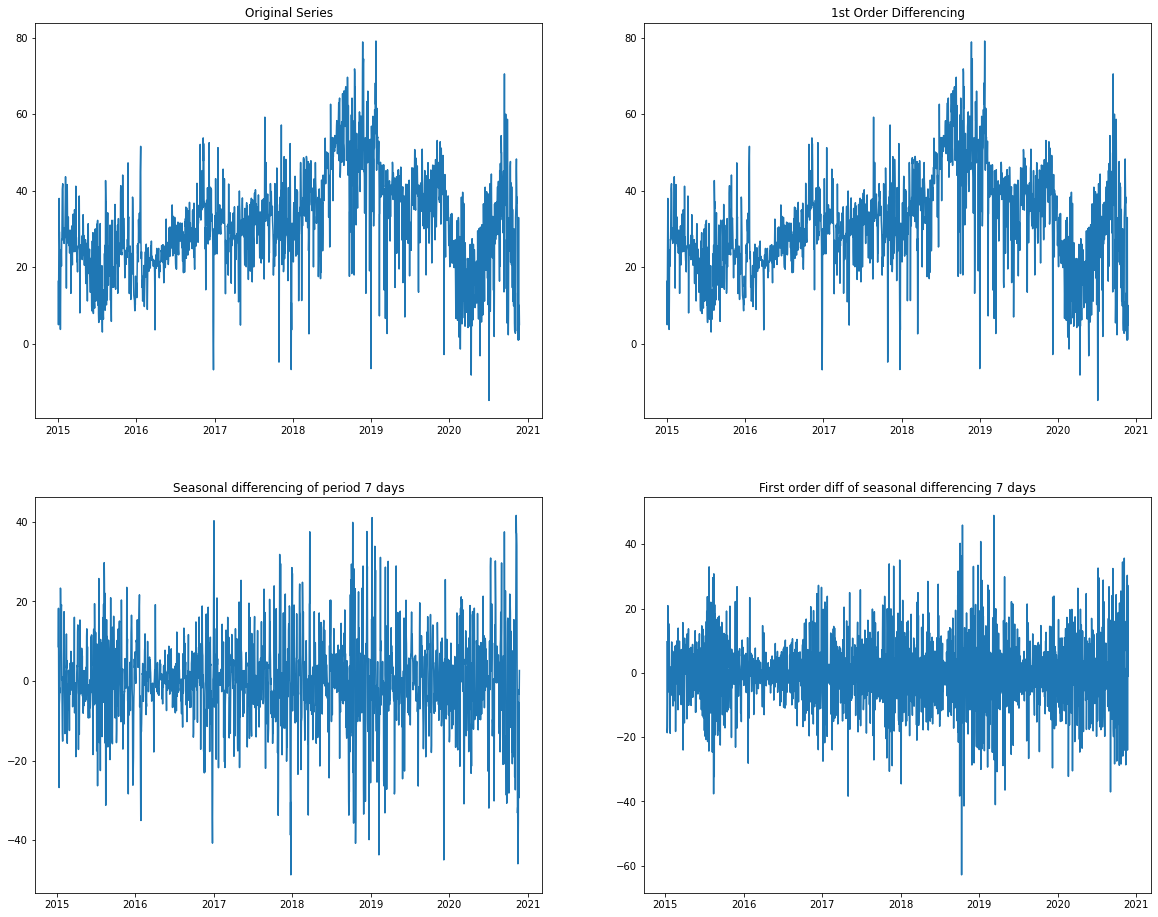

In [11]:
fig, axs = plt.subplots(2, 2, figsize=(20,16))
# Original series
axs[0,0].plot(df_daily_mean); axs[0,0].set_title('Original Series')

# Normal differencing
axs[0,1].plot(df_daily_mean); axs[0,1].set_title('1st Order Differencing')

# Seasonal differencing
axs[1,0].plot(df_daily_mean.diff(7)) # remove weekly seasonality to see stationarity
axs[1,0].set_title('Seasonal differencing of period 7 days')

# Week + Normal differencing
axs[1,1].plot(df_daily_mean.diff(7).diff(1))
axs[1,1].set_title('First order diff of seasonal differencing 7 days')

In [12]:
# default ADF test
ADF = adfuller(df_daily_mean)
print(pd.Series(ADF[0:4], index=['Test Statistic','p-value','#Lags','Observations']))

Test Statistic      -2.529509
p-value              0.108459
#Lags               26.000000
Observations      2128.000000
dtype: float64


In [13]:
# ADF test on lag week
ADF = adfuller(df_daily_mean, maxlag=7)
print(pd.Series(ADF[0:4], index=['Test Statistic','p-value','#Lags','Observations']))

Test Statistic   -5.838255e+00
p-value           3.831004e-07
#Lags             7.000000e+00
Observations      2.147000e+03
dtype: float64


### Autocorrelation

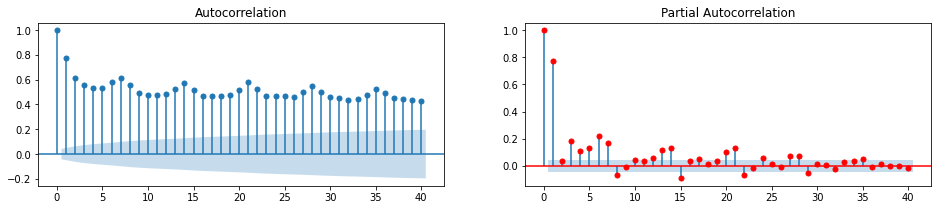

In [18]:
# plot ACF and PACF
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, axes = plt.subplots(1,2, figsize=(16,3))
plot_acf(df_daily_mean, lags=40, ax=axes[0]);
plot_pacf(df_daily_mean, lags=40, ax=axes[1], color='r');

## hyperparameters

In [41]:
# grid search the hyper params
import pmdarima as pm
smodel = pm.auto_arima(df_daily_mean, seasonal=True, m=7, 
                       start_p=0, max_p=2, start_q=0, max_q=2, # check the params max_...
                       start_P=0, max_P=2, start_Q=0, max_Q=2, 
                       trace=True, error_action='ignore', suppress_warnings=True) # The lower AIC the better

AttributeError: type object 'statsmodels.tsa.innovations._arma_innovations.arra' has no attribute '__reduce_cython__'

## SARIMAX Model

In [34]:
df_daily_mean.shape

(2155, 1)

In [36]:
# Create a correct Training/Test split to predict the last 50 points
train_df = df_daily_mean[:2150]
test_df = df_daily_mean[2150:]

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMA

# Build Model
sarima = SARIMAX(train_df,
                 order=(3, 0, 0),seasonal_order=(0,1,2,12)
                )
sarima = sarima.fit()

# Forecast
results = sarima.get_forecast(len(test_df), alpha=0.05) # 95% confidence
forecast = results.predicted_mean
confidence_int = results.conf_int()

In [ ]:
plot_forecast(forecast, train_df, test_df)

## Inference validity

In [ ]:
## plot residuals to see whether their normal distributed
residuals = pd.DataFrame(arima.resid)

fig, ax = plt.subplots(1,2, figsize=(16,3))
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Build Model
sarima = SARIMAX(engod=df['electricity_price'],
                 exog=df['day_of_week'],
                 order=(3, 0, 0),seasonal_order=(0,1,2,12)
                )
sarima = sarima.fit()

# Forecast
results = sarima.get_forecast(len(test), alpha=0.05) # 95% confidence
forecast = results.predicted_mean
confidence_int = results.conf_int()

# Prophet

[reference for model_b](https://towardsdatascience.com/multivariate-time-series-forecasting-using-random-forest-2372f3ecbad1)